# LSTM MODEL FOR SENSOR 3

## Import Libraries
This cell imports the necessary libraries for data manipulation, visualization, and machine learning.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import seaborn as sns

## Set Folder Paths
This cell sets up the folder paths for the dataset and model saving.

In [9]:
dataset_folder = "dataset/cleaned"
sensor_name = "Sensor 3"
save_folder = f"saved_model/{sensor_name}"

## Load Datasets
This cell loads the training, validation, and test datasets and sets the `created_at` column as the index.

In [10]:
train_data = pd.read_csv(
    f"{dataset_folder}/train/{sensor_name}_train.csv"
)
val_data = pd.read_csv(
    f"{dataset_folder}/val/{sensor_name}_val.csv"
)
test_data = pd.read_csv(
    f"{dataset_folder}/test/{sensor_name}_test.csv"
)

train_data["created_at"] = pd.to_datetime(train_data["created_at"], format="ISO8601")
val_data["created_at"] = pd.to_datetime(val_data["created_at"], format="ISO8601")
test_data["created_at"] = pd.to_datetime(test_data["created_at"], format="ISO8601")

train_data.set_index("created_at", inplace=True)
val_data.set_index("created_at", inplace=True)
test_data.set_index("created_at", inplace=True)

## Sample Data and Save
This cell localizes the timezone of the `created_at` index to None, samples 15 rows from the training data, and saves it to an Excel file.

In [11]:
train_data.index = train_data.index.tz_localize(None)

sample_data = train_data.sample(n=15)

sample_data.to_excel(f"{dataset_folder}/{sensor_name}_sample_data.xlsx", index=True)

print(f"Sample dataset saved as {sensor_name}_sample_data.xlsx")

Sample dataset saved as Sensor 3_sample_data.xlsx


## Select Power Column
This cell selects only the `power` column from the datasets.

In [4]:
train_data = train_data[['power']]
val_data = val_data[['power']]
test_data = test_data[['power']]

## Scale and Plot Data
This cell scales the `power` data to a range between 0 and 1 using MinMaxScaler then plot the different before and after normalization.

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

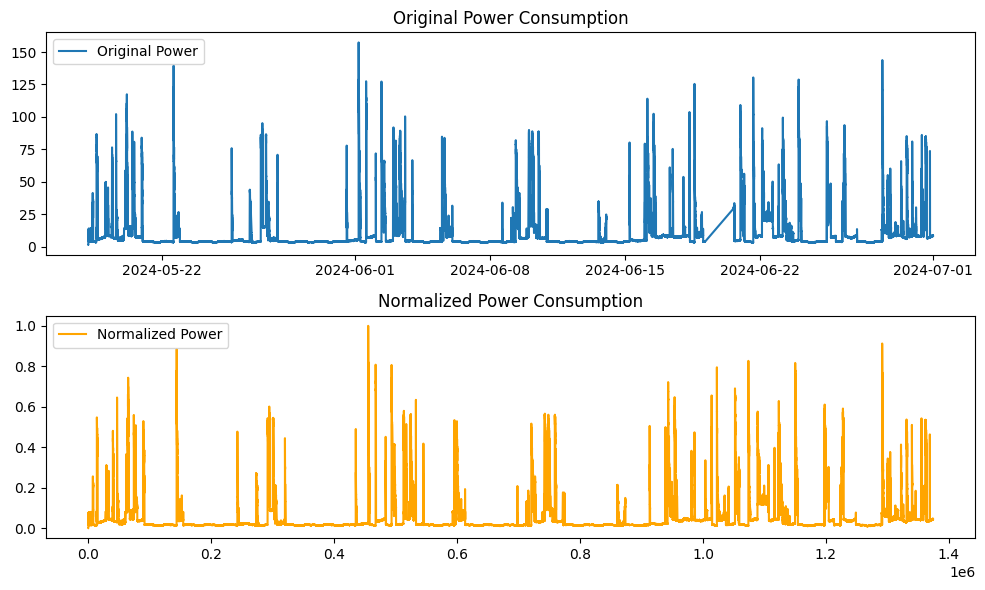

In [6]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(train_data['power'], label='Original Power')
plt.title('Original Power Consumption')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_data_scaled, label='Normalized Power', color='orange')
plt.title('Normalized Power Consumption')
plt.legend()

plt.tight_layout()
plt.show()

## Create Sequences
This cell defines a function to create sequences of data for the LSTM model and also creates sequences for the training, validation, and test datasets and reshapes them for the LSTM model.

In [6]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [7]:
X_train, y_train = create_sequences(train_data_scaled, time_steps=24)
X_val, y_val = create_sequences(val_data_scaled, time_steps=24)
X_test, y_test = create_sequences(test_data_scaled, time_steps=24)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Define and Compile Model
This cell defines the architecture of the LSTM model and compiles the model with an Adam optimizer and a learning rate scheduler.

In [8]:
# Define the LSTM model with modifications
model = Sequential()

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1))))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Additional LSTM Layer
model.add(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Final LSTM Layer
model.add(LSTM(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1))

# Compile the model with learning rate scheduler
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')

d:\Daffa Titip\power-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model
This cell trains the model with early stopping and learning rate reduction on plateau.

In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=32, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 641s 30ms/step - loss: 0.3227 - val_loss: 6.3658e-04 - learning_rate: 1.0409e-04
Epoch 2/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 564s 26ms/step - loss: 5.3307e-04 - val_loss: 5.2738e-04 - learning_rate: 1.0834e-05
Epoch 3/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 619s 29ms/step - loss: 4.6978e-04 - val_loss: 4.5484e-04 - learning_rate: 1.1277e-06
Epoch 4/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 583s 27ms/step - loss: 4.5944e-04 - val_loss: 4.6155e-04 - learning_rate: 1.1739e-07
Epoch 5/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 587s 27ms/step - loss: 4.5952e-04 - val_loss: 4.1329e-04 - learning_rate: 1.2218e-08
Epoch 6/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 593s 28ms/step - loss: 4.6198e-04 - val_loss: 4.3307e-04 - learning_rate: 1.2718e-09
Epoch 7/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 597s 28ms/step - loss: 4.5916e-04 - val_loss: 4.3869e-04 - learning_rate: 1.3238e-10
Epoch 8/32
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 596s 28ms/step - loss: 4.5956e-04 - val_loss: 4.4315e-04 

## Plot Training and Validation Loss
This cell plots the training and validation loss over epochs.

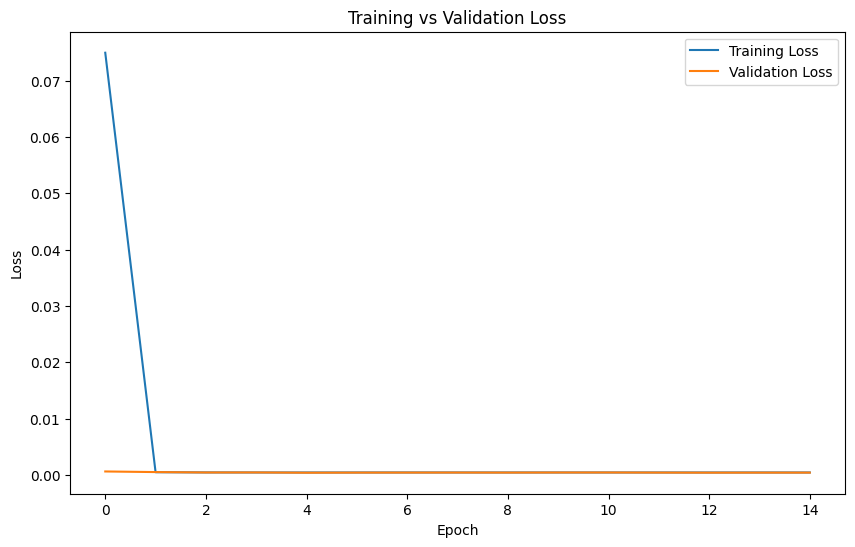

In [10]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate Model
This cell evaluates the model's performance on the test data and prints the metrics.

In [11]:
y_pred = model.predict(X_test)

10181/10181 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step


In [12]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [13]:
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Performance Metrics:
Mean Absolute Error (MAE): 0.80
Mean Squared Error (MSE): 9.47
Root Mean Squared Error (RMSE): 3.08
R² Score: 0.991


## Plot Predictions
This cell plots the true and predicted power consumption.

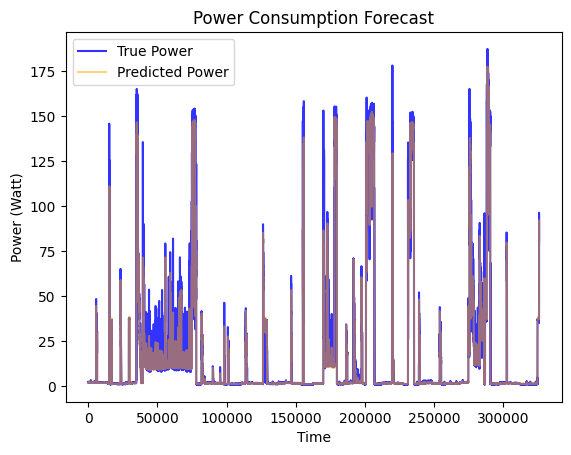

In [14]:
plt.plot(y_test_rescaled, label='True Power', color='blue', alpha=0.8)
plt.plot(y_pred_rescaled, label='Predicted Power', color='orange', alpha=0.5)
plt.legend()
plt.title("Power Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Power (Watt)")
plt.show()

## Plot Residuals
This cell plots the distribution of residuals (errors).

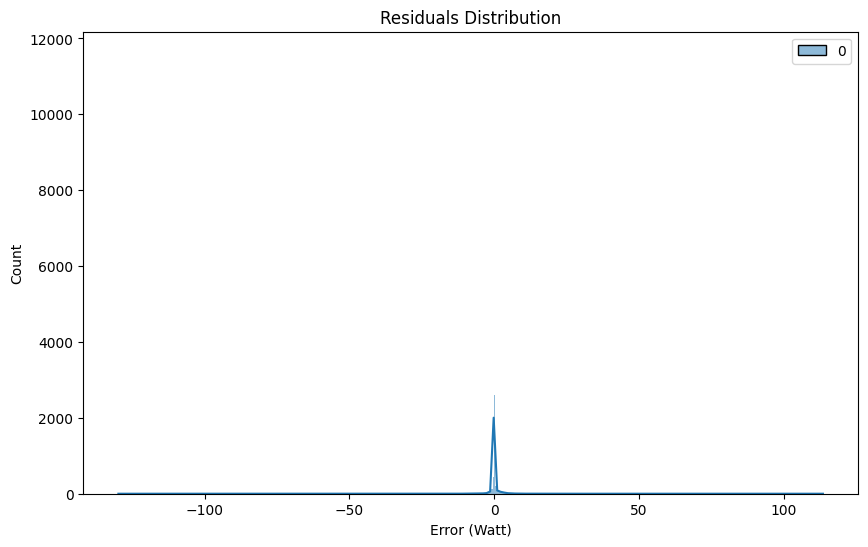

In [15]:
residuals = y_test_rescaled - y_pred_rescaled

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Error (Watt)')
plt.show()

## Calculate Daily Energy Consumption Difference
This cell calculates the daily energy consumption difference between predicted and actual values.

In [16]:
result_df = pd.DataFrame({
    'time': test_data.index[24:].strftime('%Y-%m-%dT%H:%M:%S'),
    'predicted_power': y_pred_rescaled.flatten(),
    'actual_power': y_test_rescaled.flatten(),
})

In [17]:
result_df['time'] = pd.to_datetime(result_df['time'], format="ISO8601")
result_df['date'] = result_df['time'].dt.date
daily_counts = result_df.groupby(['date']).size().reset_index(name='count')
daily_counts["date"] = daily_counts["date"].astype(str)

dates = []
predicted_energy = []
actual_energy = []
different = []

for _, row in daily_counts.iterrows():
    date = row["date"]
    
    sensor_data = result_df[result_df["date"] == pd.to_datetime(date).date()]
    sensor_data = sensor_data.sort_values(by="time")
    
    sensor_data["time_diff"] = sensor_data["time"].diff().dt.total_seconds()
    average_interval = sensor_data["time_diff"].mean()
    
    total_energy_predicted = 0
    total_energy_actual = 0
    for _, row in sensor_data.iterrows():
        predicted_power = row["predicted_power"]
        actual_power = row["actual_power"]
        interval = average_interval / 3600

        predicted_energy_value = (predicted_power * interval) / 1000
        total_energy_predicted += predicted_energy_value

        actual_energy_value = (actual_power * interval) / 1000
        total_energy_actual += actual_energy_value

    dates.append(date)
    predicted_energy.append(total_energy_predicted)
    actual_energy.append(total_energy_actual)
    different.append(total_energy_actual - total_energy_predicted)

    print(f"Different energy consumption ({date}):", total_energy_actual - total_energy_predicted, "kWh")

Different energy consumption (2024-11-10): 0.0010967670416205666 kWh
Different energy consumption (2024-11-11): 0.011742005052485072 kWh
Different energy consumption (2024-11-12): 0.011056729648206476 kWh
Different energy consumption (2024-11-13): 0.0005603991745469494 kWh
Different energy consumption (2024-11-14): -0.0008768619518731147 kWh
Different energy consumption (2024-11-15): -0.000809822014467651 kWh
Different energy consumption (2024-11-16): 0.006532587040573579 kWh
Different energy consumption (2024-11-17): 0.0068036410168959005 kWh
Different energy consumption (2024-11-18): 0.0024169831040062872 kWh
Different energy consumption (2024-11-19): 0.0011995248064216174 kWh
Different energy consumption (2024-11-20): 0.004237396434230822 kWh
Different energy consumption (2024-11-21): -0.0006705563936702935 kWh


## Plot Daily Energy Consumption
This cell plots the daily predicted and actual energy consumption.

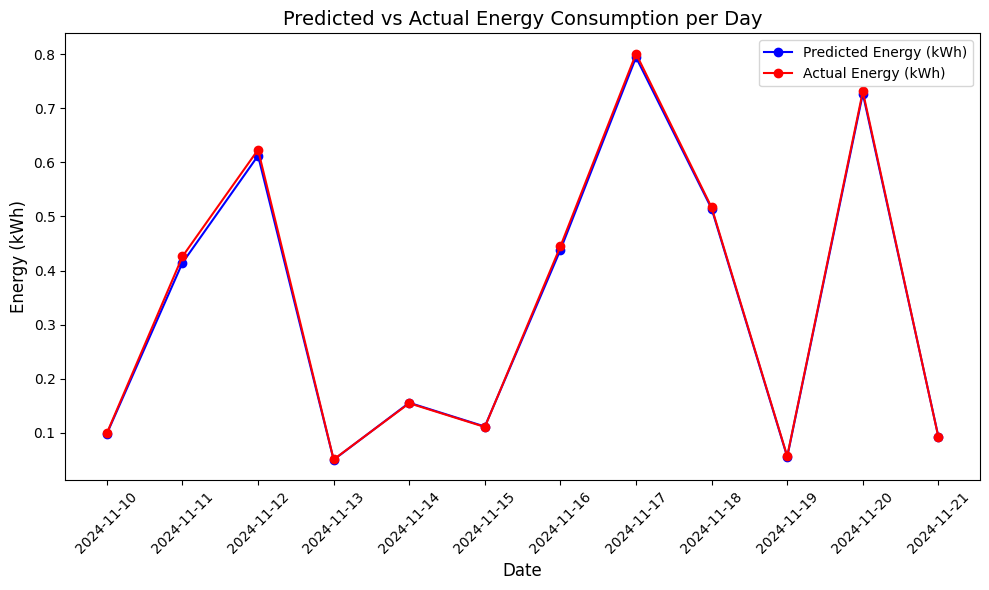

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_energy, label="Predicted Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.plot(dates, actual_energy, label="Actual Energy (kWh)", marker='o', linestyle='-', color='red')
plt.title("Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot Daily Energy Consumption Difference
This cell plots the daily difference in energy consumption between predicted and actual values.

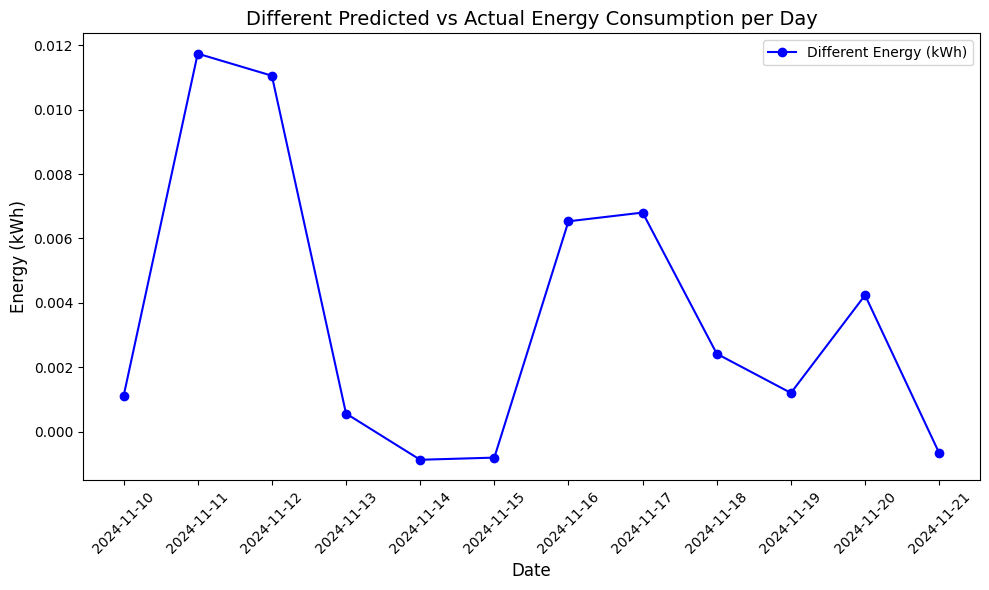

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(dates, different, label="Different Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.title("Different Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Save Model
This cell saves the trained model to an HDF5 file.

In [20]:
model.save(f"{save_folder}/{sensor_name}_model.h5")
print(f"Model saved as {sensor_name}_model.h5")

Model saved as Sensor 3_model.h5
